In [41]:
import datetime
import pandas as pd
import geopandas as gpd
from dataclasses import dataclass
import uuid

from shapely.geometry import MultiPolygon, Polygon

from matplotlib import pyplot as plt
import numpy as np

import scipy

In [2]:
df = pd.read_pickle('./Maria2019_simulation_new.pkl')

In [126]:
geom1 = df[df['windspeed'] == 19].iloc[40]['geometry'][0]
geom2 = df[df['windspeed'] == 19].iloc[10]['geometry'][0]

In [98]:
def eqinterp(vertices, dnumber):
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

In [96]:
x,y = df.iloc[0]['geometry'].exterior.coords.xy
coords = []
for xx,yy in zip(list(x),list(y)):
    coords.append(np.array((xx,yy)))

coords = np.array(coords)

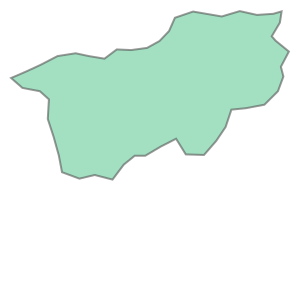

In [103]:
inter_coords = eqinterp(coords, 50)
Polygon(shell=inter_coords)

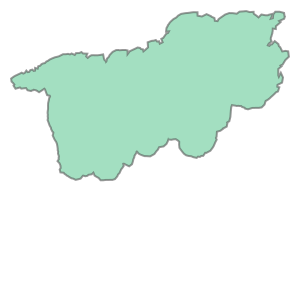

In [95]:
Polygon(shell=vertices)

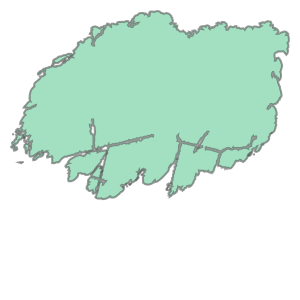

In [142]:
compareidx = '714f0cf8d475462a97c651642a3d2525'

df[(df['windspeed'] == 19) & (df['compareidx']==compareidx)].iloc[9]['geometry']

In [66]:
x = []
y = []
for coord in geom[0].exterior.coords:
    x.append(coord[0])
    y.append(coord[1])

In [72]:
dist = []
for ix in range(len(x)-1):
    x1 = x[ix+1]
    x0 = x[ix]
    
    y1 = y[ix+1]
    y0 = y[ix]
    
    dist.append(np.sqrt((x1-x0)**2 + (y1-y0)**2))

In [100]:
filter = np.ones(20)
xnew = np.convolve(x, filter, mode='valid')/len(filter)
ynew = np.convolve(y, filter, mode='valid')/len(filter)

In [115]:
geom_skipped = Polygon(shell=geom[0].exterior.coords[::10])

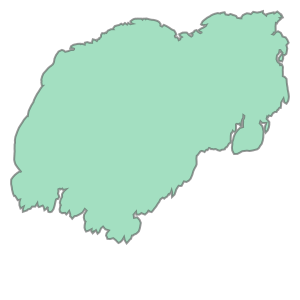

In [116]:
geom[0]

In [119]:
def reposition_coords(polygon, Ncoords):
    # Skips every len(coords)/Ncoords
    coords = polygon.exterior.coords
    if Ncoords > len(coords):
        print('Not yet defined')
        return None
    
    delta = len(coords)/Ncoords
    new_coords = []
    for ix in range(Ncoords):
        new_coords.append(coords[int(delta*ix)])
        
    return Polygon(shell=new_coords)

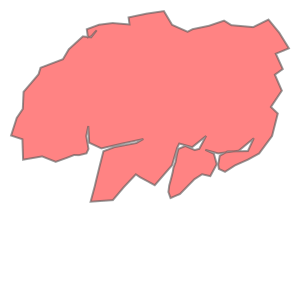

In [150]:
reposition_coords(df[(df['windspeed'] == 19) & (df['compareidx']==compareidx)].iloc[9]['geometry'][0], 100)

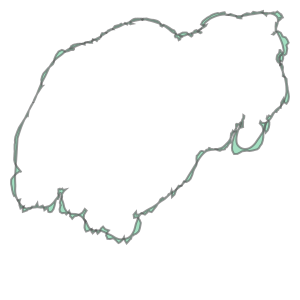

In [106]:
geom[0].union(Polygon(shell = zip(xnew,ynew))) - geom[0].intersection(Polygon(shell = zip(xnew,ynew)))

In [99]:
Polygon(shell = zip(xnew,ynew)).exterior.coords[0]

(-41726918.99999999, 30065693.000000026)

In [1]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

In [76]:
def plot_matrix(X, ax, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)

def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]


def align_vertices(interpolated_vertices):

    time_estimator = TimeEstimator(len(interpolated_vertices)-1)

    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        print(time_estimator.info_str(i), end='\r', flush=True)

        right_vertices = interpolated_vertices[i+1]


        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices
## Check reverse direction too?
            
def validate_geoms_matrix(X, aligned_geom):
    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        xx,yy = geom.exterior.xy
        xx = list(xx)
        yy = list(yy)

        geom = np.array(interpolate_perimeter(list(zip(xx, yy)), len(x)))
        # aligned_geom = interpolate_perimeter(aligned_geom, 10*len(x))
        
#         geom = align_vertices([aligned_geom, geom])[1]
        
#         xx,yy = geom.exterior.xy
#         xx = list(xx)
#         yy = list(yy)
        geom = np.array(interpolate_perimeter(align_vertices([aligned_geom, geom])[1], len(x)))


        X[:,i] = geom.flatten()

    return X

In [94]:
a = np.eye(10, dtype=int)

for i in range(len(a)):
    right_neighbor = (i+2)%len(a)
    left_neighbor = (i-2+len(a))%len(a)
    a[right_neighbor,i] = 1
    a[left_neighbor,i] = 1
    
a

array([[1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 1]])

In [97]:
adjacency_matrix = np.eye(len(Py))
for i in range(len(Py)):
    right_neighbor = (i+2)%len(Py)
    left_neighbor = (i-2+len(Py))%len(Py)
    right_neighbor2 = (i+4)%len(Py)
    left_neighbor2 = (i-4+len(Py))%len(Py)
    
    adjacency_matrix[right_neighbor,i] = 1
    adjacency_matrix[left_neighbor,i] = 1
    adjacency_matrix[right_neighbor2,i] = 1
    adjacency_matrix[left_neighbor2,i] = 1
    

In [96]:
np.matmul(Py_inv, Py)

array([[ 1.00000000e+00, -7.85407930e-16, -6.15142933e-01, ...,
         1.21259311e-17,  2.11752352e-07,  1.21384313e-16],
       [-5.22268889e-17,  1.00000000e+00,  1.34847779e-16, ...,
        -8.35140197e-07,  1.34157692e-15,  6.43762269e-06],
       [ 6.12141547e-16,  1.18834205e-15,  1.30935988e+00, ...,
         3.71549682e-18, -4.50724572e-07,  3.97708827e-17],
       ...,
       [-2.19429909e-17,  2.32900744e-16,  2.31272498e-18, ...,
        -3.96372921e-01,  8.90850894e-16,  3.05541431e+00],
       [ 3.19163987e-17,  4.65582526e-16, -7.26419799e-08, ...,
         2.10697733e-16,  2.21712095e+00, -3.42421534e-15],
       [ 2.44203111e-17, -1.72441073e-16, -2.61844612e-18, ...,
         1.19268957e+00, -8.17576295e-16, -1.60973320e+00]])

In [105]:
Xt = np.genfromtxt('../data/X0.csv', delimiter=',')
Y = np.genfromtxt('../data/Y.csv', delimiter=',')

nsamples = Y.shape[1]

xt = Xt.mean(axis=1, keepdims=True)
y = Y.mean(axis=1, keepdims=True)

Ex = Xt - xt.repeat(nsamples, axis=1)
Ey = Y - y.repeat(nsamples, axis=1)

Py = 1/(nsamples-1)*np.matmul(Ey, Ey.T)*adjacency_matrix
Pxy = 1/(nsamples-1)*np.matmul(Ex, Ey.T)*adjacency_matrix

max_Py = abs(Py).max()
max_Pxy = abs(Pxy).max()
Py /= max_Py
Pxy /= max_Pxy

Py_inv = np.linalg.pinv(Py, hermitian=True)

assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
# K = np.matmul(Pxy, Py_inv)

#### Update the state ensemble
X = Xt + np.matmul(K, (Y - Xt))

### TODO ####
# Fix invalid geometries
aligned_geom = X[:,0].reshape(100,2)
X = validate_geoms_matrix(X, aligned_geom)



In [120]:
Py = 1/(nsamples-1)*np.matmul(Ey, Ey.T)*adjacency_matrix
Pxy = 1/(nsamples-1)*np.matmul(Ex, Ey.T)*adjacency_matrix

Pxy[:10, :10]

array([[ 39.88524477,   0.        , 134.37789201,  -0.        ,
        125.29355931,  -0.        ,   0.        ,  -0.        ,
          0.        ,  -0.        ],
       [  0.        , -95.79890761,  -0.        , -32.42666419,
          0.        ,  48.10496367,   0.        ,  -0.        ,
          0.        ,  -0.        ],
       [289.68591182,  -0.        ,  98.60197838,  -0.        ,
        184.72750237,  -0.        , 290.77228618,  -0.        ,
         -0.        ,  -0.        ],
       [  0.        , -62.94309875,  -0.        , -11.67552487,
          0.        , 117.85582815,   0.        ,  81.2557451 ,
          0.        ,   0.        ],
       [213.73501447,   0.        , 205.27298588,  -0.        ,
        127.94627976,   0.        , 347.28637445,  -0.        ,
         24.32448179,   0.        ],
       [ -0.        , 367.25581738,   0.        , 441.35677633,
         -0.        , 443.45035562,  -0.        , 510.38979565,
         -0.        , 458.21863311],
       [  

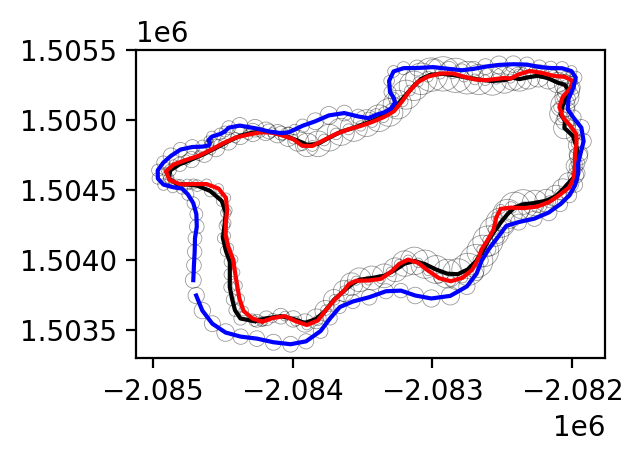

In [108]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
# plot_matrix(X_0_lst[0], ax=ax, color='blue')
plot_matrix(X, ax=ax, color='black', show_stdev=True, label=r'$X$')
plot_matrix(Xt, ax=ax, color='red', show_stdev=True, label=r'$X_t$')
plot_matrix(Y, ax=ax, color='blue', show_stdev=True, label=r'$Y$')


# ax.legend()
ax.set_aspect('equal')
# plt.imshow(state.Xt_1)

In [37]:
aligned_geom[:,0]

array([-2084667.98477535, -2084720.12504358, -2084722.54876333,
       -2084803.49403138, -2084947.3903454 , -2085091.28665942,
       -2085228.08609303, -2085080.10496742, -2084932.1238418 ,
       -2084978.54692145, -2085101.85035317, -2085225.1537849 ,
       -2085348.45721662, -2085347.75012652, -2085217.87697964,
       -2085088.00383276, -2085034.64352728, -2085091.31590672,
       -2084935.90674719, -2084780.10325244, -2084780.10325244,
       -2084644.87587352, -2084505.65701491, -2084353.60868665,
       -2084438.70392822, -2084302.35434545, -2084198.27264808,
       -2084138.34877963, -2084088.05948426, -2084023.5673238 ,
       -2083923.256962  , -2083828.46038698, -2083840.83601135,
       -2083819.30643241, -2083706.04910916, -2083592.79178591,
       -2083479.53446266, -2083377.64516392, -2083484.76023859,
       -2083591.87531327, -2083698.99038795, -2083646.35798492,
       -2083504.47976015, -2083348.89096475, -2083273.90387467,
       -2083223.0485869 , -2083187.23093

### Plot one geometry at a time

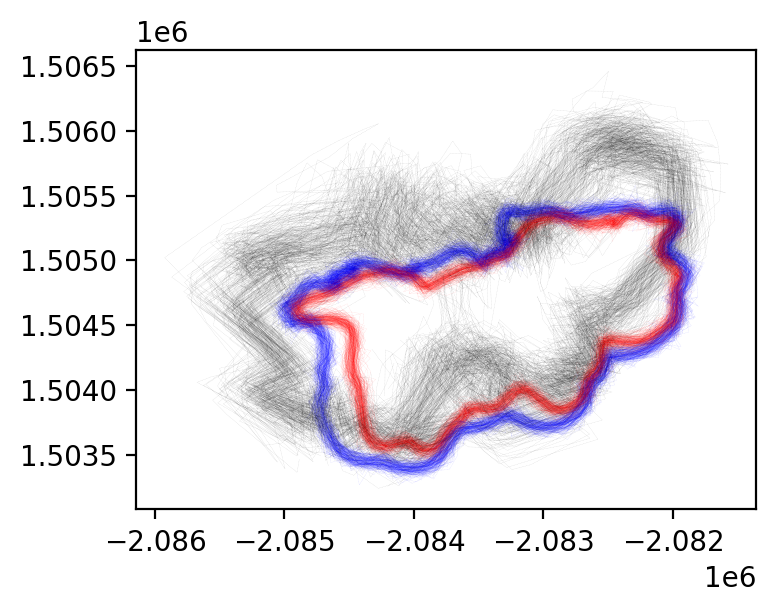

In [104]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

# aligned_geom = X[:,0].reshape(100,2)
# X = validate_geoms_matrix(X, aligned_geom)

i = 0
c = 'red'
ls='--'
ploti = range(0,250)
lw=0.1
alpha = 0.2
pt=0

for i in ploti:
    ax.plot(X[::2,i], X[1::2,i], color='black', ls=ls, lw=lw, alpha=alpha)
    ax.plot(Xt[::2,i], Xt[1::2,i], color='red', ls=ls, lw=lw, alpha=alpha)
    ax.plot(Y[::2,i], Y[1::2,i], color='blue', ls=ls, lw=lw, alpha=alpha)
    # ax.plot(X[2*pt,i], X[2*pt+1,i], color=c, marker='o', alpha=0.5)

    
# ax.plot(aligned_geom[:,0], aligned_geom[:,1], 'k--')
# ax.plot(aligned_geom[pt,0], aligned_geom[pt,1], 'ko')


ax.set_xlim((-2086143.2994979804, -2081355.5180012344))
ax.set_ylim((1503077.50523176, 1506622.097051478))
ax.set_aspect('equal')


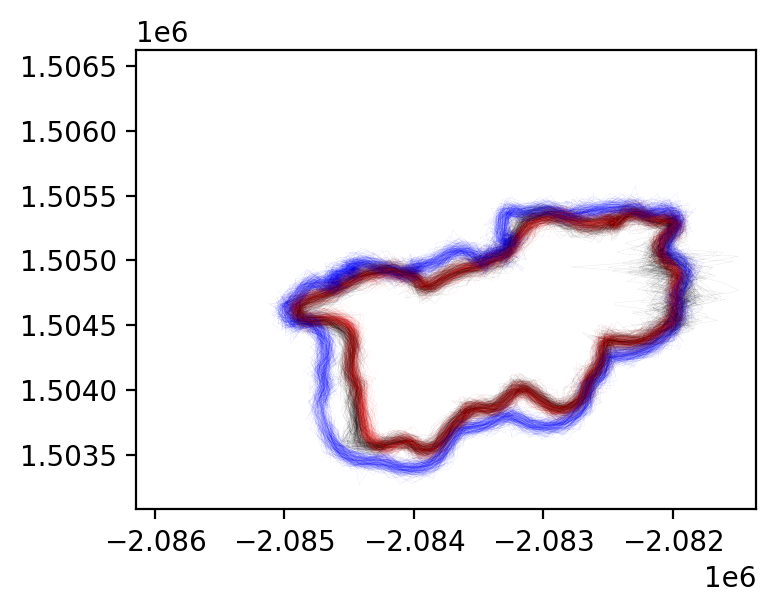

In [106]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

# aligned_geom = X[:,0].reshape(100,2)
# X = validate_geoms_matrix(X, aligned_geom)

i = 0
c = 'red'
ls='--'
ploti = range(0,250)
lw=0.1
alpha = 0.2
pt=0

for i in ploti:
    ax.plot(X[::2,i], X[1::2,i], color='black', ls=ls, lw=lw, alpha=alpha)
    ax.plot(Xt[::2,i], Xt[1::2,i], color='red', ls=ls, lw=lw, alpha=alpha)
    ax.plot(Y[::2,i], Y[1::2,i], color='blue', ls=ls, lw=lw, alpha=alpha)
    # ax.plot(X[2*pt,i], X[2*pt+1,i], color=c, marker='o', alpha=0.5)

    
# ax.plot(aligned_geom[:,0], aligned_geom[:,1], 'k--')
# ax.plot(aligned_geom[pt,0], aligned_geom[pt,1], 'ko')


ax.set_xlim((-2086143.2994979804, -2081355.5180012344))
ax.set_ylim((1503077.50523176, 1506622.097051478))
ax.set_aspect('equal')


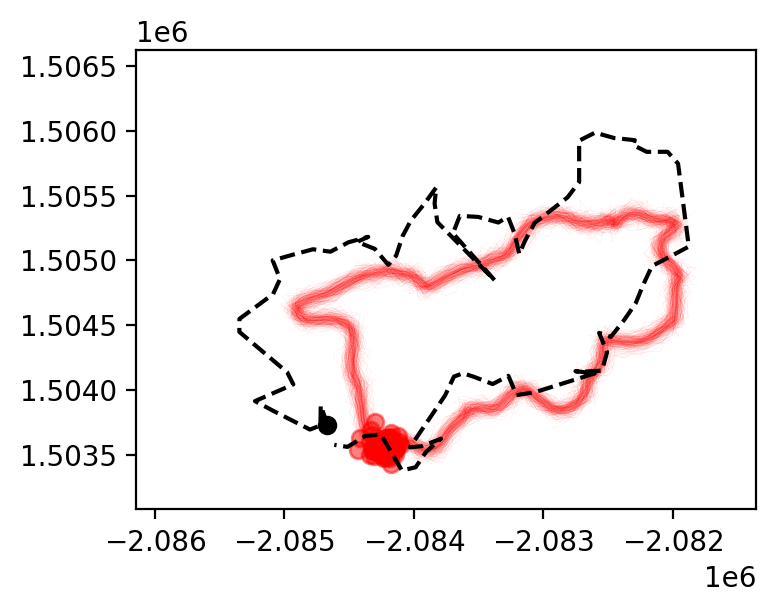

In [89]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

aligned_geom = X[:,0].reshape(100,2)
# X = validate_geoms_matrix(X, aligned_geom)

i = 0
c = 'red'
ls='--'
ploti = range(0,250)
lw=0.1
alpha = 0.2
pt=0

for i in ploti:
    # ax.plot(X[::2,i], X[1::2,i], color='black', ls=ls, lw=lw, alpha=alpha)
    ax.plot(Xt[::2,i], Xt[1::2,i], color='red', ls=ls, lw=lw, alpha=alpha)
    # ax.plot(Y[::2,i], Y[1::2,i], color='blue', ls=ls, lw=lw, alpha=alpha)
    ax.plot(Xt[2*pt,i], Xt[2*pt+1,i], color='red', marker='o', alpha=0.5)

    
ax.plot(aligned_geom[:,0], aligned_geom[:,1], 'k--')
ax.plot(aligned_geom[pt,0], aligned_geom[pt,1], 'ko')


ax.set_xlim((-2086143.2994979804, -2081355.5180012344))
ax.set_ylim((1503077.50523176, 1506622.097051478))
ax.set_aspect('equal')


In [85]:
print(f'ax.set_xlim({ax.get_xlim()})')
print(f'ax.set_ylim({ax.get_ylim()})')

ax.set_xlim((-2086143.2994979804, -2081355.5180012344))
ax.set_ylim((1503077.50523176, 1506622.097051478))


In [2]:
import numpy as np

In [11]:
d = 20
N = 100
M = 100

Ex = np.random.uniform(size=((2*d+2),N))
Ey = np.random.uniform(size=(2*d,M))

In [21]:
Py = 1/(2*d-1)*np.matmul(Ey, Ey.T)
Pxy = 1/(2*d-1)*np.matmul(Ex, Ey.T)
Pyinv = np.linalg.pinv(Py, hermitian=True)
K = np.matmul(Pxy, Pyinv)
C = np.eye(2*d, 2*d+2)

In [20]:
np.matmul(K, 

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])